Osnabrück University - Computer Vision (Winter Term 2018/19) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, December 9, 2018**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

A periodic function is a function that repeats it values after a given interval, i.e. considering a real function $f:\mathbb{R}\to\mathbb{R}$, this function will be considered periodic, with period length $\lambda\in\mathbb{R}$, if
$$f(x+\lambda) = f(x)\qquad\text{for all $x\in\mathbb{R}$}$$

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

The amplitude of a periodic function is a measure of its change over a single period. For the standard sine curve $x\mapsto \sin(x)$, the *peak amplitude*, i.e. the height of the highest peak, is $1$ while the *peak-to-peak amplitude*, i.e. the difference between the hightes peak and the lowest through, is $2$. The *wavelenght* is just the period of the sine function, i.e. $\lambda = 2\pi$, while the frequency is its inverse $f=\frac{1}{2\pi}$. One can scale the function value to change the amplitude and the argument to change the frequency/wavelength. So 
$a\cdot\sin(\frac{2\pi}{w}x)$ will give curve with amplitude $a$ and wavelength $w$.

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

A standard way to introduce sine and cosine for complex arguments is based on the fact that the real sine and cosine can be introduced as power series
$$\sin(x) = \sum _{n=0}^{\infty }{\frac {(-1)^{n}}{(2n+1)!}}x^{2n+1}
\qquad\text{and}\qquad
\cos(x) = \sum _{n=0}^{\infty }{\frac {(-1)^{n}}{(2n)!}}x^{2n}$$
This definition can be directly applied to complex arguments. Many of the known trigonometric properties generalize to this case. For purely real arguments, this definition simplifies to the real case.

## Assignment 1: Edge-based segmentation  [5 Points]

### a) Gradients
What is the gradient of a pixel? How do we calculate the first, how the second derivative of an image?  

The gradient of a pixel is given by the difference in contrast to its neighboring pixels (4- or 8-neighborhood). The gradient points into the direction with highest divergence. We can imagine an image as a function consisting of two variables (x- and y-achses) and its color shading in each pixel as the outcome. The whole image presents a landscape of valleys and hills in respect to it shading and coloring. A sobel-filtered image presents the first derivative of each pixel while the laplace-filter creates the second derivative. 

### b) Edge linking

Describe in your own words the idea of edge linking. What is the goal? Why does it not necessarily yield closed
edge contours?

After initial segmentation, we try to link loose edges.
* at the start all pixels are marked as unprocessed
* make random pixel a start pixel
* from the start pixel, look perpendicular to the gradient of the start pixel if there are other pixels with similar gradient
* if yes and unprocessed we add them to the edge and make them the new start pixel
* if none can be found we initalize another random start pixel

Why does it not necessarily yield closed edge contours?
* edge linking only considers unprocessed pixels within a certain proximity
* it just searches within the direction of the gradient

### c) Zero crossings

Explain what zero crossings are. Why does the detection of zero crossings always lead to closed contours?

A zero crossing is a point where a function switches signs.

Why does the detection of zero crossings always lead to closed contours?
* A zero crossing always entails a corresponding zero crossing. Zero crossing mark the contours of segments.

### c) Zero crossings (implementation)

Provide an implementation of the zero crossing procedure described in (CV-07 slide 71). To get sensible results you should smooth the image before applying the Laplacian filter, e.g. using the Laplacian of a Gaussian (you may use buildin functions for the filterings steps).

float64
1.0


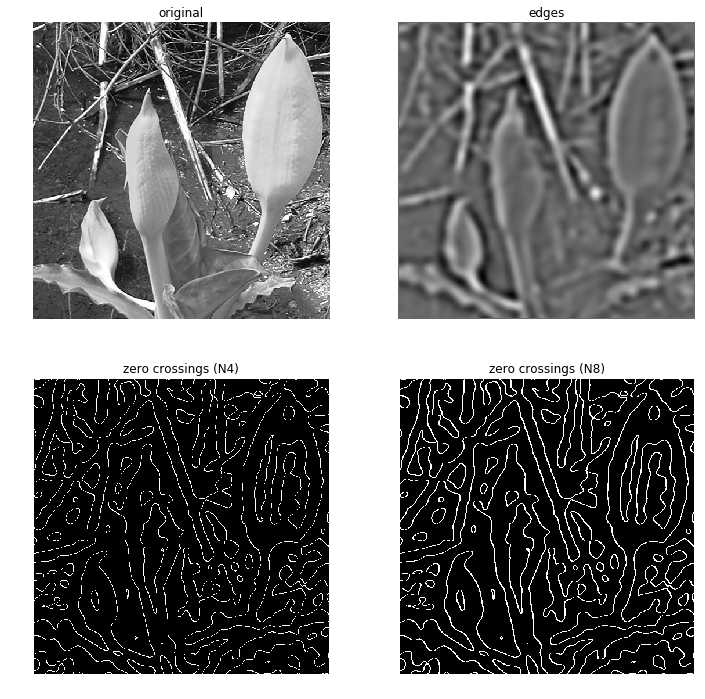

In [10]:
from skimage import filters, io
import matplotlib.pyplot as plt
%matplotlib inline

img = io.imread('images/swampflower.png').astype(float)
img /= img.max()

# Now compute edges and then zero crossings using the 4-neighborhood and the 8-neighborhood
# BEGIN SOLUTION

# from scipy.ndimage.filters import laplace, gaussian_laplace
# smooth the image
img_smoothed = filters.gaussian(img, sigma=8) # or 2.0, 4.0

# detect edges using a laplacian filter
edges = filters.laplace(img_smoothed)

# N4 neighborhood
zero_crossings_n4 = (edges[:-1, 1:] * edges[1:, 1:] <= 0) | (edges[1:, :-1] * edges[1:, 1:] <= 0)

# N8 neighborhood
zero_crossings_n8 = (zero_crossings_n4[:, 1:] 
                     | (edges[:-1, 1:-1] * edges[1:, :-2] <= 0) 
                     | (edges[:-1, 1:-1] * edges[1:, 2:] <= 0))
# END SOLUTION

plt.figure(figsize=(12, 12))
plt.gray()

plt.subplot(2,2,1); plt.axis('off'); plt.imshow(img); plt.title('original')
plt.subplot(2,2,2); plt.axis('off'); plt.imshow(edges); plt.title('edges')
plt.subplot(2,2,3); plt.axis('off'); plt.imshow(zero_crossings_n4); plt.title('zero crossings (N4)')
plt.subplot(2,2,4); plt.axis('off'); plt.imshow(zero_crossings_n8); plt.title('zero crossings (N8)' )

plt.show()

## Assignment 2: Watershed transform  [5 Points]



### a) Watershed transform

Explain in your own words the idea of watershed transform. How do the two different approaches from the lecture work? Why does watershed transform always give a closed contour?



Idea of watershed:
Find the boundaries were water would meet if the whole region was iteratively flooded.

How do the two different approaches from the lecture work?
* rain: assume that it rains on all pixels. Water flows opposite to the gradient.
* flood: ground water level is contionously rising

Why does watershed transform always give a closed contour?
* The image is "continous" in both dimensions there always is a local maxima.

### b) Implementation

Now implement the watershed transform using the flooding approach (CV-07 slide 76, but note, that the algorithm presented there is somewhat simplified!). Obviously, buildins for computing watershed transform are not allowed, but all other functions may be used. In this example we appply the watershed transform to a distance transformed image, so you **do not** have to take the gradient image, but can apply the watershed transform directly.

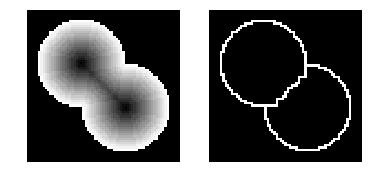

In [27]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline


def watershed(img, step=1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img (ndarray): The grayscale image.
        step (int): The rise of the waterlevel at each step. Default 1.
        
    Returns:
        edges (ndarray): A binary image containing the watersheds.
    """


    NO_LABEL = 0
    WATERSHED = 1
    new_label = 2

    # initialize labels
    label = np.zeros(img.shape, np.uint16)

    # BEGIN SOLUTION

    for level in np.arange(np.ceil(img.min()), np.ceil(img.max()) + 1, step):
        # Remember highest label that was assigned in the last iteration.
        previous_new_label = new_label
        for r, c in np.argwhere((img <= level) & (label == NO_LABEL)):
            # Get labels of neighbors.
            neighbors = label[max(0, r - 1):min(img.shape[0], r + 2),
                              max(0, c - 1):min(img.shape[1], c + 2)]
            flooded = np.unique(neighbors[neighbors > WATERSHED])
            
            if flooded.size == 0:
                # Pixel is isoloated: invent a new label.
                new_label += 1
                label[r, c] = new_label
            elif flooded.size == 1:
                # Pixel has homogenous neighborhood.
                label[r, c] = flooded[0]
            else:
                # Pixels has inhomogenous neighborhood.
                old = flooded[flooded <  previous_new_label] # Neighbors flooded with previous waterlevels.
                new = flooded[flooded >= previous_new_label] # Neighbors flooded with current waterlevel.
                # If region is flooded for the first time, give all newly flooded neighbors the same label.
                if old.size == 0:
                    label[r, c] = new[0]
                    label[np.isin(label, new[1:])] = label[r, c]
                # If parts of the region were flooded before, propagate old label
                # to newly flooded pixels.
                elif old.size == 1:
                    label[r, c] = old[0]
                    label[np.isin(label, new)] = label[r, c]
                # Two or more independtly flooded regions meet here,
                # hence the pixel is a watershed.
                else:
                    label[r, c] = WATERSHED            
    edges = (label == WATERSHED)
    return edges
    # END SOLUTION



img = imageio.imread('images/dist_circles.png', pilmode='L')

plt.gray()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(watershed(img))
plt.show()

### c) Application: maze

You can use watershed transform to find your way through a maze. To do so, first apply a distance transform to the maze and the flood the result. The watershed will show you the way through the maze. Explain why this works.
You can use build-in functions instead of your own watershed function.

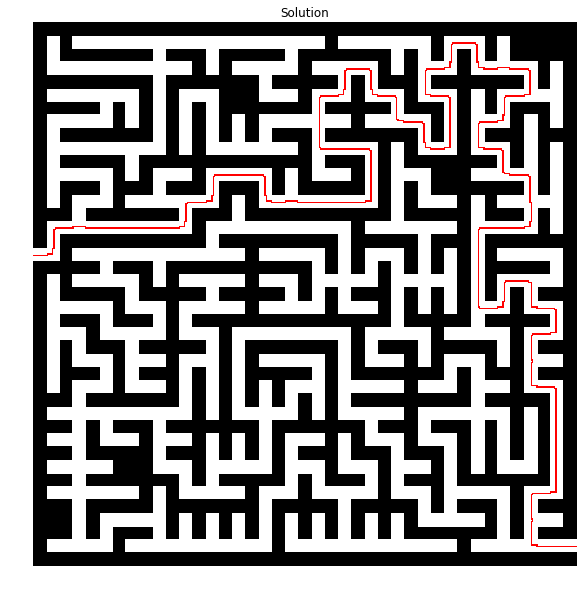

In [29]:
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
%matplotlib inline

img = imageio.imread('images/maze2.png', pilmode = 'L') # 'maze1.png' or 'maze2.png'

result = img[:, :, np.newaxis].repeat(3, 2)
# BEGIN SOLUTION
result[watershed(distance_transform_edt(img)), 1:3] = 0
# END SOLUTION

plt.figure(figsize=(10, 10))
plt.title('Solution')
plt.axis('off')
plt.gray()
plt.imshow(result)
plt.show()

The distance transformed image has its highest values when the points are most distance to the edges.
The watershed transform will mark those local maxima as a way through the maze.

## Assignment 3: $k$-means segmentation [5 Points]


**a)** Explain the idea of $k$-means clustering and how it can be used for segmentation.

In $k$-means clustering, $k$ initial reference points (cluster centers) are choosen randomly. Every point in the dataset will be assigned to the closest reference point, thereby forming $k$ initial clusters. Then the $k$ refrence points are moved towards the mean (center of gravity) of their respecetive cluster. This relocation of reference points may result in some points changing their label. This process is repeated until some given condition is fulfilled (e.g. number of iterations, no significant change, ...).

In "color segmentation", one tries to find clusters in some color space. Then points in the image are labeled by the color cluster to which they belong. Notice, that this in general does not result in "segments" that are spatially connected (as would be required by our definition of segment, CV-07 slide 6), e.g. there may be multiple red segments in an image. Hence one may be forced to relabel the results to get real segments.

**b)** Implement k-means clustering for color segmentation of an RGB image (no use of `scipy.cluster.vq.kmeans` or similar functions allowed here, but you may use functions like `numpy.mean`, `scipy.spatial.distance.pdist` and similar utility functions). Stop calculation when center vectors do not change more than a predefined threshold. Avoid empty clusters by re-initializing the corresponding center vector. (Empirically) determine a good value for $k$ for clustering the image 'peppers.png'.
**Bonus** If you want you can visualize the intermediate steps of the clustering process.

First lets take a look at how our image looks in RGB colorspace. 

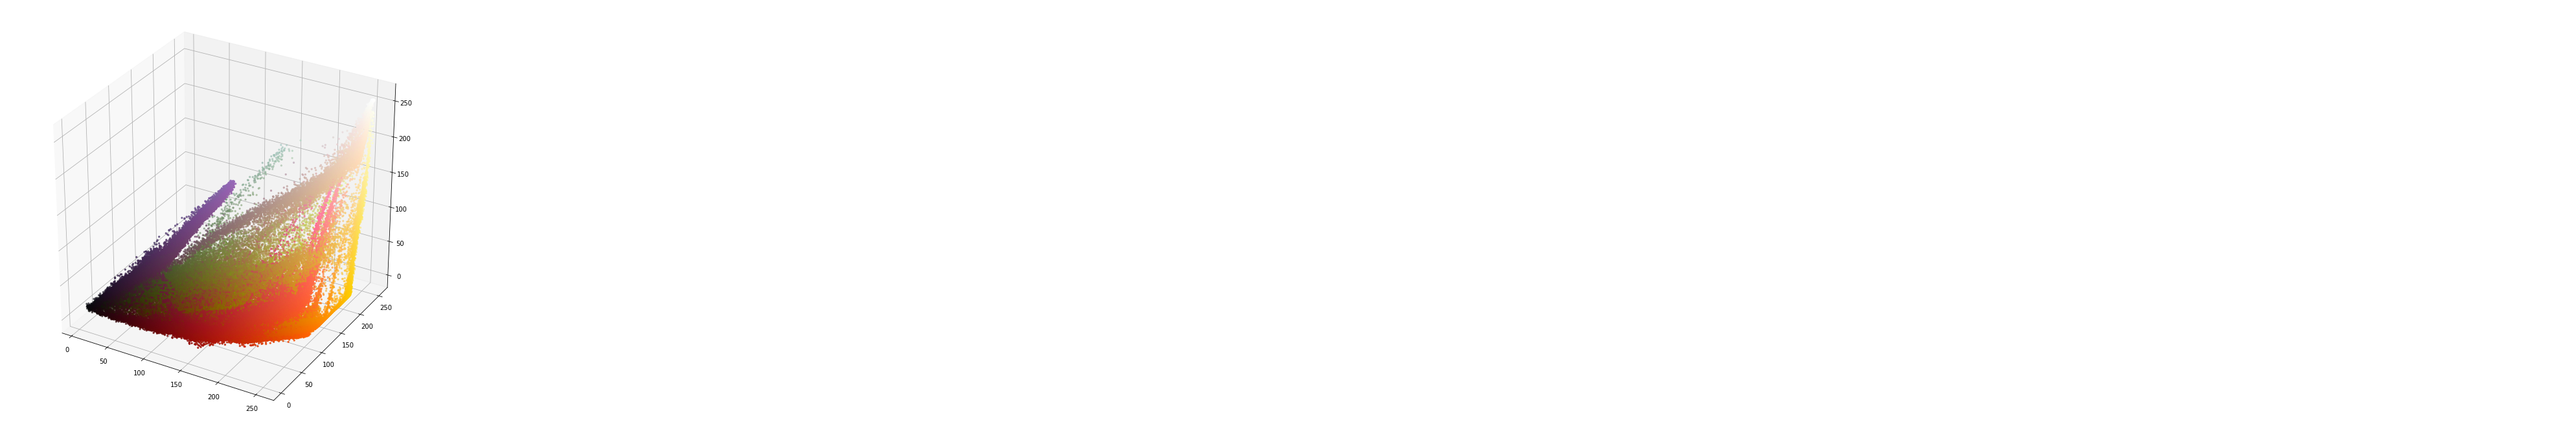

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

img = io.imread('images/peppers.png')
vec = img.reshape((-1, img.shape[2]))
vec_scaled = vec / 255
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ret = ax.scatter(vec[:, 0], vec[:, 1], vec[:, 2], c=vec_scaled, marker='.')

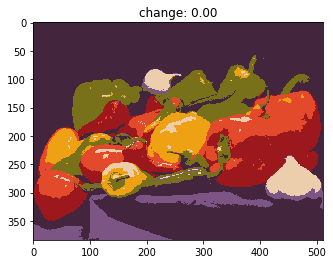

(384, 512)
(7, 3)
6
(384, 512, 3)


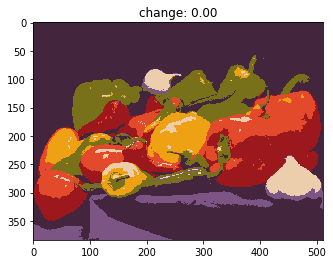

In [7]:
import numpy as np
from scipy.spatial import distance
from IPython import display
from skimage import io
import time
import matplotlib.pyplot as plt
%matplotlib inline


def kmeans_rgb(img, k, threshold=0, do_display=None):
    """
    k-means clustering in RGB space.

    Args:
        img (numpy.ndarray): an RGB image
        k (int): the number of clusters
        threshold (float): Maximal change for convergence criterion.
        do_display (bool): Whether or not to plot, intermediate steps.
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): 'number of clusters' x 3 array. 
            RGB color for each cluster center.
    """
    # BEGIN SOLUTION

    # Transform image into n_pixels 3-dimensional vectors.
    vec = img.reshape((-1, img.shape[2]))
    n_pixels = vec.shape[0]

    # Initialize random center vectors from data set.
    random_indices = np.random.choice(n_pixels, size=k, replace=False)
    centers = vec[random_indices]

    change = float('Inf')
    while change > threshold:
        # Remember previous centers.
        old_centers = centers.copy()
            
        # Calculate distance and best matching center vector.
        cluster = distance.cdist(vec, centers).argmin(axis=1)

        # Recalculate cluster centers.
        for i in range(k):
            idx = cluster == i
            if idx.any():
                centers[i] = vec[idx].mean(axis=0)
            else:
                # No vector is a match for this center vector.
                # Re-initialize center vector.
                centers[i] = vec[np.random.randint(n_pixels)]

        change = np.sum(np.linalg.norm(centers - old_centers))
        
        if do_display:
            plt.imshow(centers[cluster].reshape(img.shape))
            plt.title('change: {:.2f}'.format(change))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.1)
        elif do_display is not None:
            print(change)
        
    cluster = cluster.reshape(img.shape[:2])

    print(cluster.shape)
    print(centers.shape)
    print(cluster.max())
    print(centers[cluster].shape)
    
    return cluster, centers
    # END SOLUTION


img = io.imread('images/peppers.png')

cluster, centers = kmeans_rgb(img, k=7, threshold=0, do_display=True)
plt.imshow(centers[cluster])
plt.show()

**c)** Now do the same in the HSV space (remember its special topological structure). Check if you can improve the results by ignoring some of the HSV channels.

1.1357019135433895
0.4756934801716303
0.27068536555446854
0.17462471389882767
0.14904189465930748
0.0870933587178778
0.046474240962454214
0.030423247607980007
0.023936583703178492
0.024964632690212884
0.022202869060179826
0.02047704181612388
0.01962415526976294
0.01991054150143755
0.020772913393412654
0.02175670183800452
0.02325555780745289
0.02294813292795886
0.02515661967913826
0.02838559467524639
0.030742055488020843
0.03652288209968368
0.03644348593621411
0.03747875976469305
0.03494690308683672
0.03489934116154479
0.030722252662109085
0.035248157313553075
0.06727635191070372
0.08743057333861026
0.041935075104229676
0.016455490488311676
0.005974699300616003


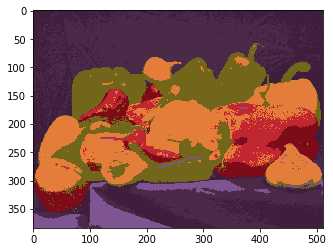

In [25]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import color, io
%matplotlib inline
# from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

img = imageio.imread('images/peppers.png', pilmode = 'RGB')

def kmeans_hsv(img, k, threshold = 0):
    """
    k-means clustering in HSV space.

    Args:
        img (numpy.ndarray): an HSV image
        k (int): the number of clusters
        threshold (float): 
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """
    # BEGIN SOLUTION
    # transform image into a vector
    # allow for single channel and hsv images
    img = np.atleast_3d(img)
    vec = img.reshape((-1,img.shape[-1]))
    pixels = vec.shape[0]

    # initialize random center vectors from data set
    centers = vec[np.random.choice(pixels, k, replace=False)]

    change = float('Inf')
    while change > threshold:
        # remember previous centers
        old_centers = centers
            
        # calculate distance and best matching center vector
        cluster = distance.cdist(vec,centers).argmin(1)

        # recalculate cluster centers
        centers = np.empty(centers.shape, centers.dtype)
        for i in range(k):
            idx = cluster == i
            if idx.any():
                centers[i] = vec[idx].mean(0)
            else:
                # no vector is a match for this center vector
                # Re-initialize center vector
                centers[i] = vec[np.random.randint(pixels)]

        change = np.sqrt(((centers-old_centers) ** 2).sum(1)).sum()
        print(change)
        
    cluster = cluster.reshape(img.shape[0:2])
    # END SOLUTION
    return cluster, centers


img_hsv = color.rgb2hsv(img)
k = 7
theta = 0.01

cluster, centers_hsv = kmeans_hsv(img_hsv[:,:,:], k, theta)
if (centers_hsv.shape[1] == 3):
    plt.imshow(color.hsv2rgb(centers_hsv[cluster]))
else:
    plt.gray()
    plt.imshow(np.squeeze(centers_hsv[cluster]))
plt.show()


## Assignment 4: Interactive Region Growing [5 Points]

Implement flood fill as described in (CV07 slides 123ff.).

In a recursive implementation the floodfill function is called for the seed pixel. In the function a recursive call for the four neighbouring pixels is made, if the color of the pixel, the function is called with, is similar to the seed color. If this is the case the pixel is added to the region. [Other](https://en.wikipedia.org/wiki/Flood_fill) more elegant solutions exist aswell.

The function `on_press` is called when a mouse button is pressed inside the canvas. From there call `floodfill`. Use the filtered hsv image `img_filtered` for your computation, and show the computed region around the seed point (the position where the mousebutton was pressed) in the original image. You may use a mask to save which pixels belong the the region (and to save which pixels you already visited). 

Hint: If you can not see the image, try restarting the kernel.

<IPython.core.display.Javascript object>


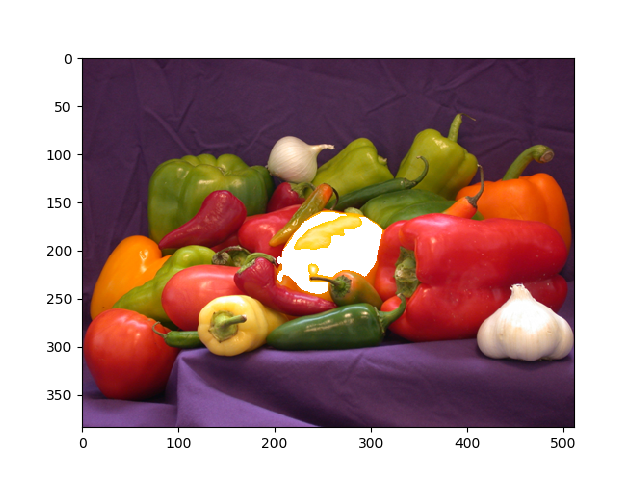

In [3]:
%matplotlib notebook
import imageio
import math
import numpy as np
from matplotlib import pyplot as plt
from skimage import color
import scipy.ndimage as ndimage
from sys import setrecursionlimit

threshold = .08;

setrecursionlimit(100000)

def floodfill(img, mask, x, y, color):
    """Recursively grows region around seed point
    
    Args: 
        img (ndarray): The image in which the region is grown
        mask (boolean ndarray): Visited pixels which belong to the region.
        x (uint): X coordinate of the pixel. Checks if this pixels belongs to the region
        y (uint): Y coordinate of the pixel.
        color (list): The color at the seed position
    """
    # BEGIN SOLUTION
    if (np.all(np.abs(img[x ,y , 0] - color) < threshold) or np.all(1 - (np.abs(img[x,y,0] - color)) < threshold)) and not mask[x,y]:
        mask[x,y] = True
        if x > 0:
            floodfill(img, mask, x-1, y, color)
        if x < img.shape[0] - 1:
            floodfill(img, mask, x+1, y, color)
        if y > 0:
            floodfill(img, mask,x, y-1, color)
        if y < img.shape[1] - 1:
            floodfill(img, mask,x, y+1, color)
    # END SOLUTION

def on_press(event):
    """Mouse button press event handler
    
    Args:
        event: The mouse event
    """
    y = math.floor(event.xdata)
    x = math.floor(event.ydata)
    color = img_filtered[x, y, :]
    # BEGIN SOLUTION
    mask = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    floodfill(img_filtered, mask, x, y, color)
    img[mask] = (255,255,255)
    
    # END SOLUTION
    plt.imshow(img)
    fig.canvas.draw()
    

def fill_from_pixel(img, img_filtered, x,y):
    """ Calls floodfill from a pixel position
    
    Args:
        img (ndarray): IO image on which fill is drawn.
        img_filtered (ndarray): Processing image on which floodfill is computed.
        x (uint): Coordinates of pixel position.
        y (uint): Coordinates of pixel position.

    Returns:
        img (ndarray): Image with grown area in white
    """
    mask = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    color = img_filtered[x,y, :]
    floodfill(img_filtered, mask, x, y, color)
    img[mask] = (255,255,255)
    
    return img


img = imageio.imread('images/peppers.png')
img_hsv = color.rgb2hsv(img)
img_filtered = ndimage.median_filter(img_hsv, 5)
img = fill_from_pixel(img, img_filtered, 200, 300) # Comment in to deactivate simple testing at fixed position
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img)

fig.canvas.mpl_connect('button_press_event', on_press)

plt.show()